# Import Dependencies

In [33]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster, metrics
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm

np.random.seed(0)

%matplotlib inline

# Load dataset

<AxesSubplot:xlabel='weeks worked in year', ylabel='wage per hour'>

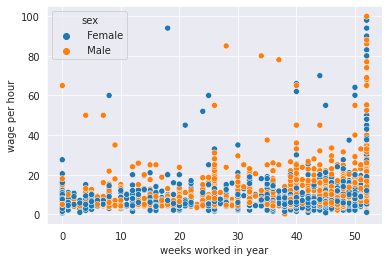

In [34]:
censusIncome = pd.read_csv('../data/census-income.data', sep=',')
censusIncome.sample(frac=1, random_state=42).reset_index(drop=True)

dataNumerical = [
    'wage per hour',
    'weeks worked in year',
]

dataCategorical = [
    # 'education',
    # 'race',
    # 'sex',
]

# Fix the high values of the wage per hour
censusIncome['wage per hour'] = censusIncome['wage per hour'].apply(lambda w: w / 100)

filteredCensus = censusIncome[
    (censusIncome['class of worker'] != ' Not in universe') &
    (censusIncome['education'] != ' Children') &
    (censusIncome['wage per hour'] > 0)
    ]

filteredData = filteredCensus.copy(deep=True)
importantColumns = dataCategorical + dataNumerical

for c in dataCategorical:
    # factorize returns an array of numerical categories and uniques => we are only interested in numerical categories => take index [0]
    # start the categories by one, not zero => + 1
    filteredData[c] = pd.factorize(filteredData[c])[0] + 1

# filteredData.describe()
importantData = filteredData[importantColumns]

sns.scatterplot(y='wage per hour', x='weeks worked in year', data=filteredData, hue='sex')

I chose other data than in the dimensionality reduction exercise, because the combination of columns from the second exercise doesn't produce good data to be clustered.

I tried to plot the wage per hour in combination the wage per hour. I think that people that get more wage per hour will work more weeks in a year. This is seen in the plot where people who work 52 weeks in one year get the most money.

# Clustering

In [35]:
importantData

,wage per hour,weeks worked in year
5,12.00,52
8,8.76,52
22,5.00,32
49,4.00,52
147,4.50,48
...,...,...
199410,10.57,52
199438,11.00,52
199439,11.95,52
199441,16.75,52


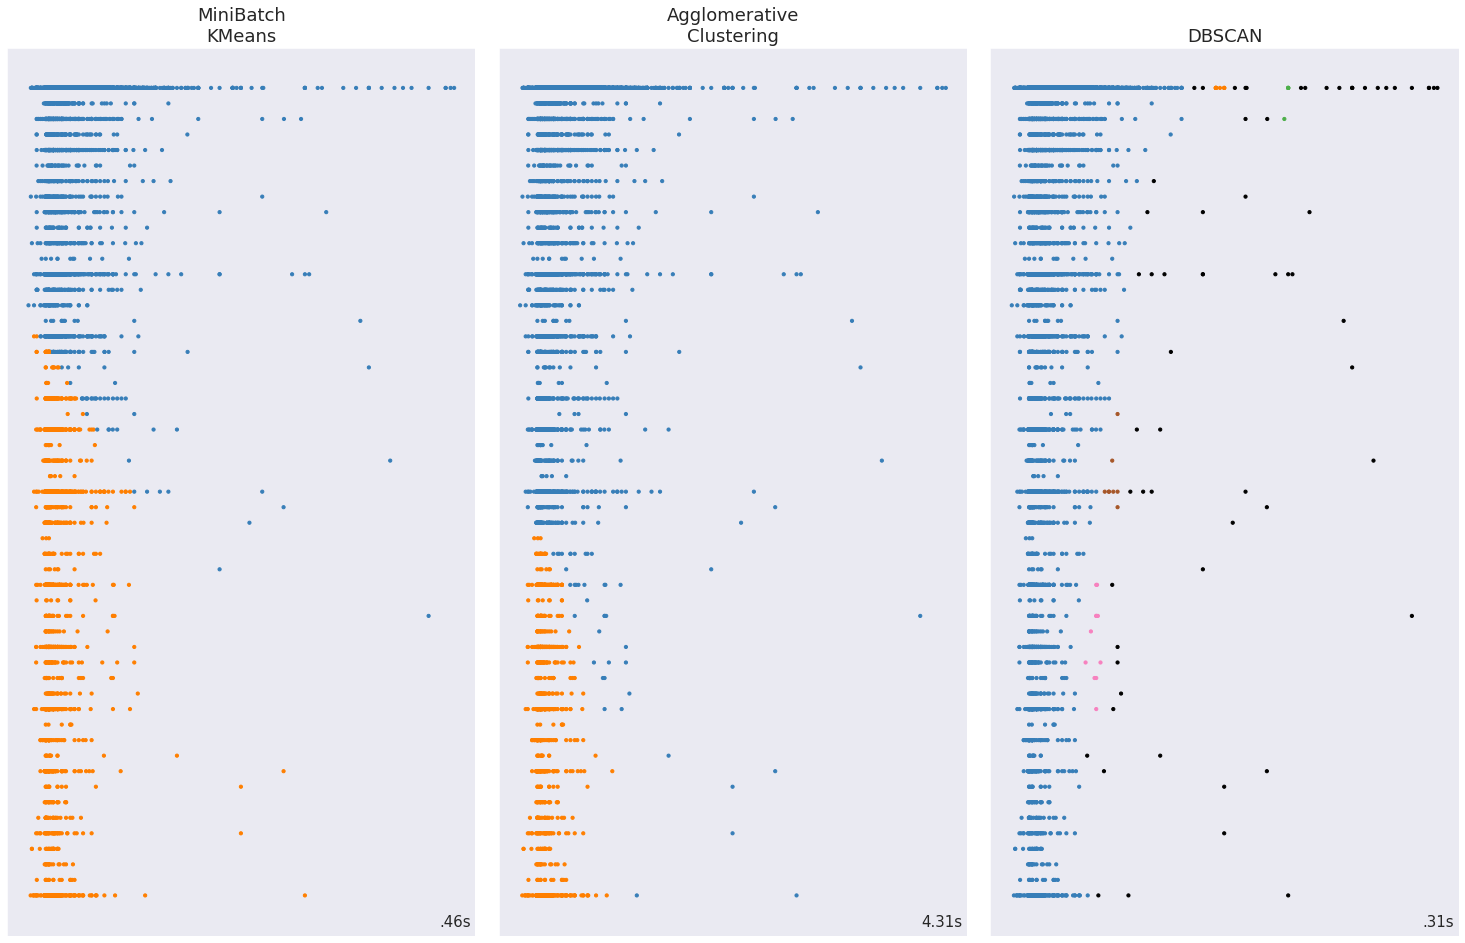

In [36]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)
plot_num = 1

default_base = {
    "eps": 0.3,
    "n_clusters": 2,
}

params = default_base.copy()

X = importantData

X = StandardScaler().fit_transform(X)

two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
ward_linkage = cluster.AgglomerativeClustering(
    n_clusters=params["n_clusters"],
)
dbscan = cluster.DBSCAN(eps=params["eps"])

clustering_algorithms = (
    ("MiniBatch\nKMeans", two_means),  # Partitive
    ("Agglomerative\nClustering", ward_linkage),  # Hierarchical
    ("DBSCAN", dbscan),  # Partitive
)

for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the "
                    + "connectivity matrix is [0-9]{1,2}"
                    + " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning,
        )
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
                    + " may not work as expected.",
            category=UserWarning,
        )
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(1, len(clustering_algorithms), plot_num)
    plt.title(name, size=18)

    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()

# Results

## k-means and Agglomerative clustering

In the picture below we have the results for 2 clusters. Both algorithms found different results. k-means produced a larger upper cluster, whereas agglomerative clustering produced a smaller lower cluster.

![census-income-cluster-2](./img/census-income-c-2.png)

In the picture below we have the results for 4 clusters, comparing the k-means and agglomerative clustering. The clusters that the algorithms found, are quite different.

![census-income-cluster-4](./img/census-income-c-4.png)

In the picture below we have the results for 8 clusters. The clusters that the algorithms found, are quite different.

![census-income-cluster-8](./img/census-income-c-8.png)

## DBSCAN

As we see the algorithm produces fewer clusters as the eps value is higher. The eps value is for defining the term dense in the algorithm. Higher values mean that the data must be more dense.

This is the dbscan algorithm for the eps 0.1 value. In this image we see about 29 small clusters. Some clusters have only point.

![census-income-eps-0.1](./img/census-income-e-0.1.png)

This is the dbscan algorithm for the eps 0.3 value. With a higher value we can see 6 clusters in the image.

![census-income-eps-0.3](./img/census-income-e-0.3.png)

This is the dbscan algorithm for the eps 0.6 value. In the picture we can see 4 clusters.

![census-income-eps-0.6](./img/census-income-e-0.6.png)



# Comparison

Next we compare the algorithms with the silhouette score. A higher score means that the clusters are better defined.

## Ward Silhouette Score

In [ ]:
clusters = [2, 3, 4, 6, 8, 10]

for c in clusters:
    wardLinkage = cluster.AgglomerativeClustering(n_clusters=c)
    clusterLabels = wardLinkage.fit_predict(X)

    silhouetteAvg = metrics.silhouette_score(X, clusterLabels)
    print("For clusters:", c, "The silhouette score is:", silhouetteAvg)


For clusters: 2 The silhouette score is: 0.6247633946466903


I computed the silhouette score for the agglomerative clustering. I computed the silhouette for 2, 3, 4, 6, 8, 10. As more clusters i add the worse the silhouette score gets. I get the best results for 2 clusters. More than 8 clusters do not make sense as the score is not increased anymore.

The data can be clustered not very well.

## k-Means Silhouette Score

In [ ]:
clusters = [2, 3, 4, 6, 8, 10, 12]

for c in clusters:
    two_means = cluster.MiniBatchKMeans(n_clusters=c)
    clusterLabels = two_means.fit_predict(X)

    silhouetteAvg = metrics.silhouette_score(X, clusterLabels)
    print("For clusters:", c, "The silhouette score is:", silhouetteAvg)


I computed the silhouette score for the k-Means clustering. I used the same clusters as for the agglomerative clustering. The result for 2 clusters is still the best and the score gets worse with more clusters being added.

Overall the silhouette score is not very good for this dense data.

## DBSCAN Silhouette Score

In [31]:
eps = [1, 0.6, 0.3, 0.2]

for e in eps:
    dbscan = cluster.DBSCAN(eps=e)
    clusterLabels = dbscan.fit_predict(X)
    _, clusterArray = np.unique(clusterLabels, return_counts=True)
    clusters = len(clusterArray)
    silhouetteAvg = metrics.silhouette_score(X, clusterLabels)
    print("For eps", e, "and clusters:", clusters, "The silhouette score is:", silhouetteAvg, )


For eps 1 and clusters: 2 The silhouette score is: 0.81955813779984
For eps 0.6 and clusters: 4 The silhouette score is: 0.8262024131376202
For eps 0.3 and clusters: 6 The silhouette score is: 0.4423672479596339
For eps 0.2 and clusters: 8 The silhouette score is: 0.28768708805707616


Next I computed the silhouette score for the dbscan algorithm. The DBSCAN algorithm computes the clusters and do not need them as parameter. Luckily we can get the amount of clusters from the computation. The silhouette score is quite different from the other two algorithms. Here 4 clusters have the best silhouette score, followed by two clusters. The difference is very low. But for 6+ clusters the silhouette score is very bad, compared to 2 and 4 clusters.

DBSCAN looks for clusters of high density. The data is quite dense as seen in the plots above, so a low amount of clusters yields the best results

I achieved the best score with dbscan.

# Davies-Bouldin Index

This index specifies the similarity between clusters. A value that is near 0 means a better partitioning of the clsuters

In [32]:
clusters = [2, 3, 4, 6, 8, 10, 12]

for c in clusters:
    twoMeans = cluster.MiniBatchKMeans(n_clusters=c)
    twoMeansModel = two_means.fit(X)
    twoMeansLabels = twoMeansModel.labels_
    twoMeansScore = metrics.davies_bouldin_score(X, twoMeansLabels)

    print("K-Means: Cluster =", c, "Score =", twoMeansScore)

for c in clusters:
    wardLinkage = cluster.AgglomerativeClustering(n_clusters=c)
    wardLinkageModel = wardLinkage.fit(X)
    wardLinkageLabels = wardLinkageModel.labels_
    wardLinkageScore = metrics.davies_bouldin_score(X, wardLinkageLabels)

    print("Agglomerative Clustering: Cluster =", c, "Score =", wardLinkageScore)

eps = [1, 0.6, 0.3, 0.2]

for e in eps:
    dbscan = cluster.DBSCAN(eps=e)
    dbscanModel = dbscan.fit(X)
    dbscanLabels = dbscanModel.labels_
    dbscanScore = metrics.davies_bouldin_score(X, dbscanLabels)

    print("DBSCAN: EPS =", e, "Score =", dbscanScore)

K-Means: Cluster = 2 Score = 0.7080191764220717
K-Means: Cluster = 3 Score = 0.6882623958042381
K-Means: Cluster = 4 Score = 0.6675668812296843
K-Means: Cluster = 6 Score = 0.7435944521496571
K-Means: Cluster = 8 Score = 0.6682124586090983
K-Means: Cluster = 10 Score = 0.6710179841125146
K-Means: Cluster = 12 Score = 0.6711469559538807
Agglomerative Clustering: Cluster = 2 Score = 0.47100776452092
Agglomerative Clustering: Cluster = 3 Score = 0.626620622824508
Agglomerative Clustering: Cluster = 4 Score = 0.5345188553059094
Agglomerative Clustering: Cluster = 6 Score = 0.6212526620328018
Agglomerative Clustering: Cluster = 8 Score = 0.7654117321064258
Agglomerative Clustering: Cluster = 10 Score = 0.6931158599269912
Agglomerative Clustering: Cluster = 12 Score = 0.7057872948208669
DBSCAN: EPS = 1 Score = 0.417387989083703
DBSCAN: EPS = 0.6 Score = 1.6402183297316526
DBSCAN: EPS = 0.3 Score = 1.3777819193328131
DBSCAN: EPS = 0.2 Score = 1.3824019108649626


Again I achieved the best score with dbscan with an eps value of 1. Agglomerative clustering obtains the best score with 2 clusters, whereas k-means obtains the best result with 4 clustering.

Overall all algorithms do not yield a result which is near 0, because the data can't be clustered very well.